In [1]:
import numpy as np
import pandas as pd
import os, sys
from astropy import units as u
import random
import h5py

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

from dtaidistance import dtw, clustering
from dtaidistance import dtw_visualisation as dtwvis

from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage

sys.path.append('/astro/users/jbirky/projects/tess_binaries')
os.environ['TESS_DATA'] = '/data/epyc/projects2/tess'

import tess_binaries as tb

Possible improvements:
- will adding periods improve hierarchical classification?
- way to visualize distances between all objects - euclidean graph?

In [21]:
ff = h5py.File(f'{tb.cat_dir}/asassn_tess_inspected.hdf5', mode="r")

df = {}
for key in list(ff):
    if key == 'type':
        df[key] = np.array(ff[key].value, dtype='str')
    else:
        df[key] = ff[key].value
    
ff.close()
sample = pd.DataFrame(data=df)

/epyc/opt/anaconda/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


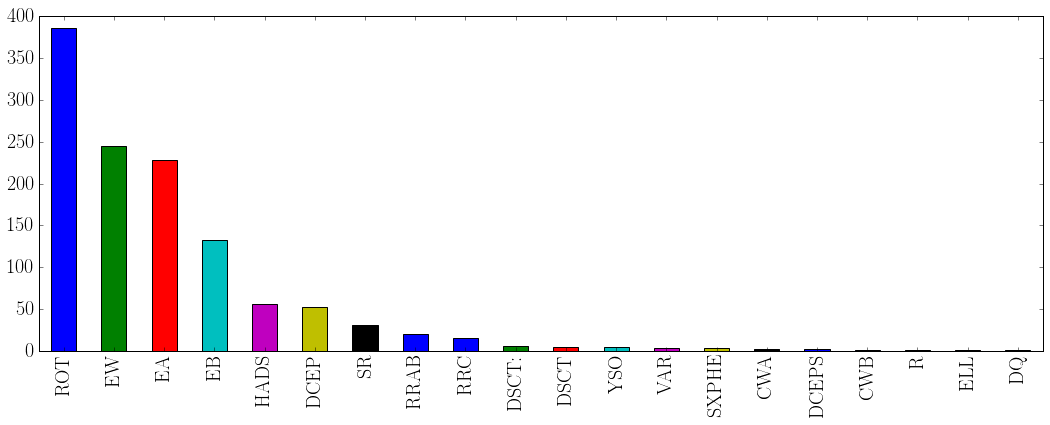

In [7]:
sample['type'].value_counts().plot(kind='bar', figsize=[18,6])

/epyc/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/epyc/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


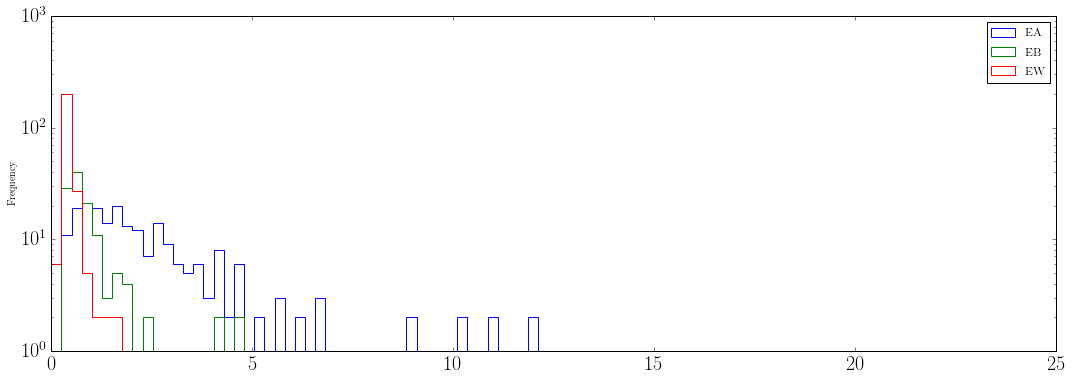

In [8]:
for typ in ['EA', 'EB', 'EW']:
    sample[sample['type'] == typ]['period'].plot(kind='hist', bins=np.linspace(0,25,100), facecolor='none', histtype='step', figsize=[18,6], label=typ, logy=True).legend(loc='upper right')

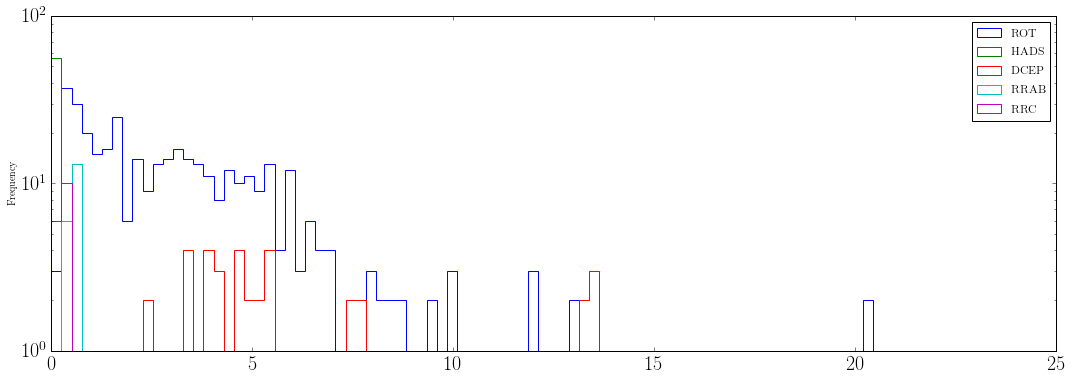

In [9]:
for typ in ['ROT', 'HADS', 'DCEP', 'RRAB', 'RRC']:
    sample[sample['type'] == typ]['period'].plot(kind='hist', bins=np.linspace(0,25,100), facecolor='none', histtype='step', figsize=[18,6], label=typ, logy=True).legend(loc='upper right')

In [40]:
N = 40
demo = np.array(random.choices(np.arange(0,len(sample)), k=N))

In [47]:
model = clustering.LinkageTree(dtw.distance_matrix_fast, {})
cluster_idx = model.fit(list(np.array(sample['flux'])[demo]))

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, N/2))
model.plot("clustering.png", axes=ax, show_ts_label=list(sample['type'][demo]),
           show_tr_label=True, ts_label_margin=0,
           ts_left_margin=0, ts_sample_length=1)

(None, None)